# This is an implementation of the Variational Bayesian Linear State Space Model with the artificial data mentioned in 
#### "Fast Variational Bayesian Linear State-Space Model" Jaakko Luttinen, ECML/PKDD, 2013 


In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sys
from bayespy.nodes import GaussianMarkovChain
from bayespy.nodes import Gaussian, GaussianARD
from bayespy.nodes import Gamma
from bayespy.nodes import SumMultiply
from bayespy.inference.vmp.nodes.gamma import diagonal
import sys, getopt, os
from bayespy.utils import random

from bayespy.inference.vmp.vmp import VB
from bayespy.inference.vmp import transformations
import theano
import bayespy.plot as bpplt
import theano.tensor as T
from theano import tensor as tt 
import pymc3 as pm

/home/nilavro/irleak/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Routines for Simulating Data 

In [2]:
def simulate_data(M, N):
    """
    Generate a dataset using linear state-space model.

    The process has two latent oscillation components and one random walk
    component.
    """
    # Simulate some data
    D = 4
    c = np.random.randn(M, D)
    w = 0.3
    a = np.array([[np.cos(w), -np.sin(w), 0, 0], 
                  [np.sin(w), np.cos(w),  0, 0], 
                  [0,         0,          1, 0],
                  [0,         0,          0, 0]])
    x = np.empty((N,D))
    f = np.empty((M,N))
    y = np.empty((M,N))
    x[0] = 10*np.random.randn(D)
    f[:,0] = np.dot(c,x[0])
    y[:,0] = f[:,0] + 4*np.random.randn(M)
    for n in range(N-1):
        x[n+1] = np.dot(a,x[n]) + np.random.randn(D)
        f[:,n+1] = np.dot(c,x[n+1])
        y[:,n+1] = f[:,n+1] + 4*np.random.randn(M)
    
    y = y.T
    return (y, x)

In [3]:
@bpplt.interactive
def demo(M=6, N=200, D=3, seed=42):
    """
    Run the demo for linear state-space model.
    """

    # Use deterministic random numbers
    if seed is not None:
        np.random.seed(seed)

    # Get data
    (y, x) = simulate_data(M, N)

    # Add missing values randomly
    mask = random.mask(M, N, p=0.3)
    # Add missing values to a period of time
    #mask[:,30:80] = False
    #y[~mask] = np.nan # BayesPy doesn't require this. Just for plotting.

    # Run inference
    '''
    Q = infer(y, D,
              mask=mask,
              rotate=rotate,
              debug=debug,
              monitor=monitor,
              maxiter=maxiter)
    '''
     
    # Show results
    plt.figure()
    #bpplt.timeseries_normal(Q['F'], scale=2)
    bpplt.timeseries(x.T, linestyle='-', color='b')
    plt.show()
    bpplt.timeseries(y.T, linestyle='-', color='r', marker='.')
    plt.show()
    return x, y

# Simulating Data as said in the paper

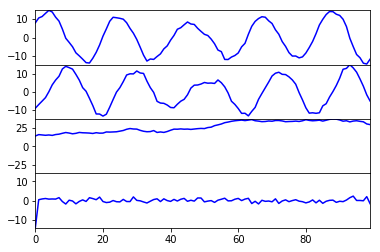

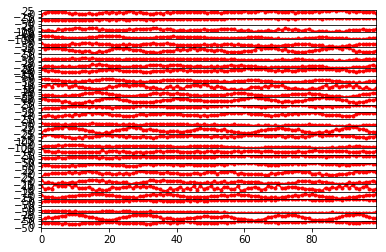

In [4]:
kwargs = {"M":30, "N":100, "D":4, "seed":42 }
(x,y) = demo(**kwargs)


# Continuous Hidden State for State Space Model

In [5]:
from pymc3 import Normal, Flat, Continuous

class StateSpaceModel(Continuous):
    """
    A state space model with Gaussian noise.
    
    This models only the state variables so that the form of the observation
    noise can be specified separately.
    
    Parameters
    ----------
    tau : tensor
        tau > 0, innovation precision
    sd : tensor 1e-5
        sd > 0, innovation standard deviation (alternative to specifying tau)
    A: tensor
        state update matrix
    B : tensor
        input matrix
    u : tensor
        (time x dim), inputs to the system
        init : distribution
        distribution for initial value (defaults to Flat())
    """
    def __init__(self, tau=None, sd=None, A=None, B=None, 
                 u=None, init=Flat.dist(), *args, **kwargs):
        super(StateSpaceModel, self).__init__(*args, **kwargs)
        self.tau = tau
        self.sd = sd
        self.A = A
        self.B = B
        self.u = u
        self.init = init
        self.mean = 0.
            
    def random(self, point=None, size=None):
        tau, sd, A,  init = draw_values([self.tau, self.sd, self.A, self.init], point=point)
        
        T, D = size
        x = np.zeros(T, D)
        x[0,:] = init
        
        for t in range(1, T):
            x[t,:] = np.dot(A, x[t-1,:].T).T +  np.random.randn(1, D) * sd
            
        return x
    
    def logp(self, x):
        tau = self.tau
        sd = self.sd 
        A = self.A
        
        init = self.init
        

        x_im1 = x[:-1]
        x_i = x[1:]
        # u_im1 = u[:-1]
        
        #  + T.dot(B, u_im1.T)
        
        innov_like = Normal.dist(mu=T.dot(A, x_im1.T), tau=tau, sd=sd).logp(x_i.T)
        return T.sum(init.logp(x[0])) + T.sum(innov_like)

# ADVI for M = 30 D = 8 N = 400 

In [16]:
M = 30
D = 8
N = 400

  
with pm.Model() as model:
    
    # x_0 = pm.Normal('x0', mu = 0, tau = 1e-5 , shape = (D))
    # x_0 = np.zeros(8)
    tau_a  = pm.Gamma('tau_a', alpha = 1e-5, beta = 1e-5 )
    A = pm.Normal('A', mu=np.eye(1), tau=tau_a, shape=(D,D))
    

    
    X = StateSpaceModel('x', A=A,  tau = 1,  shape=(y.shape[0], D))
    
    tau_c  = pm.Gamma('tau_c', alpha = 1e-5 , beta = 1e-5 )
    
    C = pm.Normal('C', mu=np.zeros((M,D)), tau=tau_c, shape=(M,D))
    
    Tau_o = pm.Gamma('tau_o', alpha=1e-5, beta=1e-5)
    
    Y = pm.Normal('y', mu=T.dot(C, X.T).T, tau=Tau_o, observed=y)
    
     

# Run ADVI 

In [17]:
with model:
    inference = pm.ADVI()
    %%time approx = pm.fit(n=150000, method=inference)
    # %%time svgd_approx = pm.fit(3000, method='svgd', inf_kwargs=dict(n_particles=1000), obj_optimizer=pm.sgd(learning_rate=0.01))
trace = approx.sample(10000)

Average Loss = 9,811.6: 100%|██████████| 150000/150000 [02:04<00:00, 1203.66it/s] 
Finished [100%]: Average Loss = 9,811.6


CPU times: user 2min 10s, sys: 8.27 s, total: 2min 19s
Wall time: 2min 8s


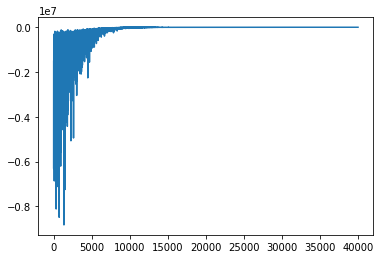

In [8]:
plt.plot(-approx.hist[0:40000])

In [ ]:
pm.traceplot(trace)

In [9]:
trace['A'].mean(axis=0)


array([[ 0.48833518,  0.25409051, -0.07939121, -0.07567731, -0.20948272,
         0.21323097, -0.18750421,  0.07592709],
       [ 0.40031746,  0.36953245,  0.03228035, -0.0086195 , -0.03497415,
         0.1070064 , -0.02624344, -0.30988338],
       [ 0.05480441,  0.11033131,  0.18427031,  0.1579307 ,  0.22439431,
         0.29431922,  0.19324286,  0.01207683],
       [-0.02232167,  0.02970477,  0.15718795,  0.14201178,  0.20771728,
         0.22547219,  0.18060565,  0.08940182],
       [-0.10425068,  0.05600893,  0.20648163,  0.17313842,  0.29814599,
         0.14564498,  0.26405851, -0.08026932],
       [ 0.22676732,  0.01396827,  0.1021195 ,  0.113959  ,  0.05370625,
         0.54005365,  0.03431376,  0.45297929],
       [-0.09944402,  0.07063119,  0.20136213,  0.16824135,  0.29327764,
         0.12648458,  0.25665013, -0.1058348 ],
       [-0.1782208 , -0.3182418 , -0.08086338, -0.00627382, -0.05442251,
         0.02478287, -0.05422764,  0.65783466]])

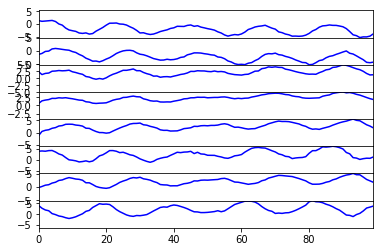

In [10]:
bpplt.timeseries(trace['x'].mean(axis = 0).T, linestyle='-', color='b')

# LSSM with known dimension of Latent variables

In [ ]:
M = 30
D = 4
N = 400


 
with pm.Model() as model:
    
    # x_0 = pm.Normal('x0', mu = 0, tau = 1e-5 , shape = (D))
    # x_0 = np.zeros(8)
    tau_a  = pm.Gamma('tau_a', alpha = 1e-5, beta = 1e-5 )
    A = pm.Normal('A', mu=np.eye(1), tau=tau_a, shape=(D,D))

     
    X = StateSpaceModel('x', A=A,  tau = tau_a,  shape=(y.shape[0], D))
    
    tau_c  = pm.Gamma('tau_c', alpha = 1e-5 , beta = 1e-5 )
    
    C = pm.Normal('C', mu=np.zeros((M,D)), tau=tau_c, shape=(M,D))
    
    Tau_o = pm.Gamma('tau_o', alpha=1e-5, beta=1e-5)
    
    Y = pm.Normal('y', mu=T.dot(C, X.T).T, tau=Tau_o, observed=y)

In [ ]:
with model:
    inference = pm.ADVI()
    %%time approx = pm.fit(n=500000, method=inference)
    # %%time svgd_approx = pm.fit(3000, method='svgd', inf_kwargs=dict(n_particles=1000), obj_optimizer=pm.sgd(learning_rate=0.01))
trace = approx.sample(10000)

In [ ]:
bpplt.timeseries(trace['x'].mean(axis = 0).T, linestyle='-', color='b')

In [ ]:
trace['A'].mean(axis=0)


# LSSM with a little more knowledge of A's dynamics i.e. it's known that values of the parameter lies within [-1,1]

In [11]:
M = 30
D = 4
N = 400


 
with pm.Model() as model:
    
    # x_0 = pm.Normal('x0', mu = 0, tau = 1e-5 , shape = (D))
    # x_0 = np.zeros(8)
    tau_a  = pm.Gamma('tau_a', alpha = 1e-5, beta = 1e-5 )
    
     
    
    w = pm.Normal('w', mu = 0, tau= 1)
    flat_A = tt.as_tensor([tt.cos(w), -tt.sin(w), 0 ,0 , tt.sin(w), tt.cos(w), 0 , 0, 0, 0, 1, 0, 0, 0, 0,0]) 
    A = flat_A.reshape((D, D)) 
    
    X = StateSpaceModel('x', A=A,  tau = 1,  shape=(y.shape[0], D))
    
    tau_c  = pm.Gamma('tau_c', alpha = 1e-5 , beta = 1e-5 )
    
    C = pm.Normal('C', mu=np.zeros((M,D)), tau=tau_c, shape=(M,D))
    
    Tau_o = pm.Gamma('tau_o', alpha=1e-5, beta=1e-5)
    
    Y = pm.Normal('y', mu=T.dot(C, X.T).T, tau=Tau_o, observed=y)

In [12]:
with model:
    inference = pm.ADVI()
    %%time approx = pm.fit(n= 100000, method=inference)
    # %%time svgd_approx = pm.fit(3000, method='svgd', inf_kwargs=dict(n_particles=1000), obj_optimizer=pm.sgd(learning_rate=0.01))
trace = approx.sample(10000)

Average Loss = 5.2857e+05: 100%|██████████| 100000/100000 [01:02<00:00, 1600.23it/s]
Finished [100%]: Average Loss = 5.2857e+05


CPU times: user 1min 7s, sys: 5.05 s, total: 1min 12s
Wall time: 1min 6s


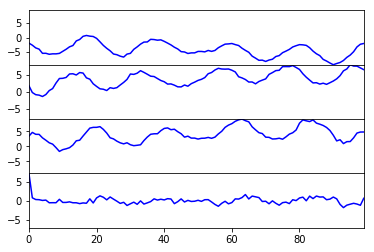

In [13]:
bpplt.timeseries(trace['x'].mean(axis = 0).T, linestyle='-', color='b')

In [14]:
trace['w'].mean(axis=0)


-0.05243727682421472

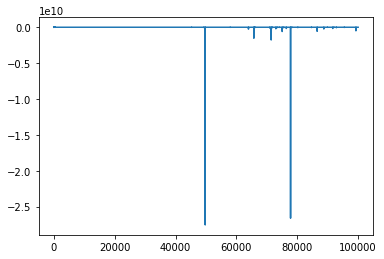

In [15]:
plt.plot(-approx.hist )

In [ ]:
with model:
   # start = pm.find_MAP(fmin=optimize.fmin_powell)
   # step1 = pm.Metropolis(vars=[A,C,Tau_o])
   # step2 = pm.Metropolis(vars=[Tau,X])
    trace = pm.sample(20000, step = pm.Slice(), start=pm.find_MAP() )

# Model Checking : Under Progress

# 1. Histogram Plot

# 2. Geweke Test

In [ ]:
from pymc3 import geweke
    
z = geweke(trace, intervals= 15)
plt.scatter(*z['w'].T)
plt.hlines([-1,1], 0, 13000, linestyles='dotted')
plt.xlim(0, 13000)

# 3.  Gelman-Rubin Test

In [ ]:
 

bfmi = pm.bfmi(trace)
pm.gelman_rubin(trace)

# 4. Goodness of fit: posterior predictive


In [ ]:
from pymc3 import sample_ppc

with model:
    trace_ppc = sample_ppc(trace, samples=500)

In [ ]:
trace_ppc[]

In [ ]:
sns.kdeplot(y , alpha=0.5, lw=5, c='b')
for i in range(2000):
    sns.kdeplot(ppc['y'][i,:,0], alpha=0.1, c='g')

In [ ]:
x.shape